# General

In [1]:
# Het importeren van de benodigde bilbiotheken
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import scipy.stats as sp
from numpy.polynomial.polynomial import polyfit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier 
from sklearn.tree import plot_tree
from sklearn.metrics import r2_score 
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

In [2]:
# Het inlezen van de bestanden
dfTelemetry = pd.read_csv('data/PdM_telemetry.csv')
dfErrors = pd.read_csv('data/PdM_errors.csv')
dfMaint = pd.read_csv('data/PdM_maint.csv')
dfFailures = pd.read_csv('data/PdM_failures.csv')
dfMachines = pd.read_csv('data/PdM_machines.csv')

In [3]:
# #Left join failures on maintenance to create df1
df1 = pd.merge(dfMaint, dfFailures, how='left', left_on=['datetime', 'machineID', 'comp'], right_on = ['datetime', 'machineID', 'failure'])
df1['failure'] = df1['failure'].fillna(0) #indicates maint was not a failure
df1.loc[((df1.failure == 'comp1') | (df1.failure == 'comp2') | (df1.failure == 'comp3') | (df1.failure == 'comp4')), 'failure'] = '1' #indicates maintenance was a failure
df1['failure'] = df1['failure'].astype(int)

#Clean error table to create df2, df2 = cleansed dfErrors tbl. 
# df2 = dfErrors
# df2['Error1'] = 0
# df2['Error2'] = 0
# df2['Error3'] = 0
# df2['Error4'] = 0
# df2['Error5'] = 0

# df2.loc[(df2['errorID'] == 'error1'), 'Error1'] = 1
# df2.loc[(df2['errorID'] == 'error2'), 'Error2'] = 1
# df2.loc[(df2['errorID'] == 'error3'), 'Error3'] = 1
# df2.loc[(df2['errorID'] == 'error4'), 'Error4'] = 1
# df2.loc[(df2['errorID'] == 'error5'), 'Error5'] = 1

# # # df2 = df2.groupby(['machineID', 'datetime']).sum() #Groups on all cols.
# df2 = df2.groupby(['datetime', 'machineID'])[[f'Error{n}' for n in range (1,6)]].sum() #Groups errorID cols only

##Create df3 by joining dfTelemetry on df2
df3 = pd.merge(dfTelemetry, dfErrors, how='left', left_on=['machineID', 'datetime'], right_on=['machineID', 'datetime'])

# df3['Error1'] = df3['Error1'].fillna(0)
# df3['Error2'] = df3['Error2'].fillna(0)
# df3['Error3'] = df3['Error3'].fillna(0)
# df3['Error4'] = df3['Error4'].fillna(0)
# df3['Error5'] = df3['Error5'].fillna(0)

# df3.Error1 = df3.Error1.astype(np.int64)
# df3.Error2 = df3.Error2.astype(np.int64)
# df3.Error3 = df3.Error3.astype(np.int64)
# df3.Error4 = df3.Error4.astype(np.int64)
# df3.Error5 = df3.Error5.astype(np.int64)

## Create df4 by joining machines on df3
df4 = pd.merge(dfMachines, df3, how='right', left_on=['machineID'], right_on=['machineID'])

## Create df5 by joining df1 on df4
df5 = pd.merge(df1, df4, how='right', left_on=['machineID', 'datetime'], right_on=['machineID', 'datetime'])
df = df5

#Create dfSmall by inner joining df1 on df4
dfSmall = pd.merge(df1, df4)

#Later toevoegen aan master branch code ------------------
#Adding date and timestamp cols from the datetime column
dfSmall['date'] = pd.to_datetime(dfSmall['datetime']).dt.date #create date column
dfSmall['timestamp'] = pd.to_datetime(dfSmall['datetime']).dt.time #create timestamp column
dfSmall.drop('datetime', axis=1, inplace=True)
col_names = ['date', 'timestamp', 'machineID', 'comp', 'failure', 'model', 'age', 'errorID', 'volt', 'rotate', 'pressure', 'vibration']
# 'Error1', 'Error2', 'Error3', 'Error4', 'Error5'
dfSmall = dfSmall.reindex(columns=col_names)

#Doing the exact same thing for the whole df
df['date'] = pd.to_datetime(df['datetime']).dt.date #create date column
df['timestamp'] = pd.to_datetime(df['datetime']).dt.time #create timestamp column
df.drop('datetime', axis=1, inplace=True)
col_names = ['date', 'timestamp', 'machineID', 'comp', 'failure', 'model', 'age', 'errorID',  'volt', 'rotate', 'pressure', 'vibration']
df = df.reindex(columns=col_names)
dfSmall.head()

,date,timestamp,machineID,comp,failure,model,age,errorID,volt,rotate,pressure,vibration
0,2015-01-05,06:00:00,1,comp4,1,model3,18,NaN,179.303153,499.777962,111.833028,52.383097
1,2015-01-05,06:00:00,1,comp1,0,model3,18,NaN,179.303153,499.777962,111.833028,52.383097
2,2015-01-20,06:00:00,1,comp3,0,model3,18,NaN,157.774510,442.816748,105.160692,42.135127
3,2015-01-20,06:00:00,1,comp1,0,model3,18,NaN,157.774510,442.816748,105.160692,42.135127
4,2015-02-04,06:00:00,1,comp4,0,model3,18,NaN,198.120032,438.210053,89.040265,41.887215


# Building algorithms


## Decision Tree <br>
Het eerste algoritme dat wordt uitgewerkt voor het voorspellen van een failure is een decision tree. Een decision tree heeft als sterkte dat deze gemakkelijk is te interpreteren en zowel op basis van continue als discrete waardes opgebouwd kan worden.

In [4]:
## validating values
# dfSmall.head()
# print(dfSmall['failure'].unique())
# print(dfSmall['machineID'].unique())
# dfSmall['failure'].value_counts()
df['failure'].value_counts()

0.0    2143
1.0     743
Name: failure, dtype: int64

### Decision tree op dfSmall waarbij aantal failures gelijk zijn
+ date niet meegenomen
+ timestamp niet meegenomen

In [5]:
dfFailureEqual = dfSmall.sort_values(by=['failure'])
dfFailureEqual = dfFailureEqual.reset_index(drop=True)
dfFailureEqual = dfFailureEqual.drop(dfFailureEqual.index[0:1400]) ##Deleting 1400 rows to equalize the 1's and 0's in failure. Only 1400 rows remain
dfFailureEqual['failure'] = dfFailureEqual['failure'].astype(np.int64)

In [6]:
# Defining X and y
X = dfFailureEqual.drop(['failure', 'date', 'timestamp'], axis=1).copy()
y = dfFailureEqual['failure'].copy()

# One-hot-encoded for comp column
X_encoded = pd.get_dummies(X, columns=['comp', 'model', 'errorID'])

X_encoded.rename(columns={'comp_comp1': 'comp_1', 'comp_comp2': 'comp_2', 'comp_comp3': 'comp_3', 'comp_comp4': 'comp_4',
                          'model_model1': 'model_1', 'model_model2': 'model_2', 'model_model3': 'model_3', 'model_model4': 'model_4',
                          'errorID_error1': 'error_1', 'errorID_error2': 'error_2', 'errorID_error3': 'error_3', 'errorID_error4': 'error_4', 'errorID_error5': 'error_5' 
                          }, inplace=True)
X_encoded.head()

,machineID,age,volt,rotate,pressure,vibration,comp_1,comp_2,comp_3,comp_4,model_1,model_2,model_3,model_4,error_1,error_3,error_4,error_5
1400,29,3,204.350714,408.114846,109.282362,44.681533,1,0,0,0,0,0,0,1,0,0,0,0
1401,5,2,176.225625,466.894380,95.751321,42.851711,0,0,0,1,0,0,1,0,0,0,0,0
1402,29,3,187.184128,433.944949,80.027608,48.766751,1,0,0,0,0,0,0,1,0,0,0,0
1403,29,3,157.582454,531.761232,96.631983,37.153844,0,0,0,1,0,0,0,1,0,0,0,0
1404,29,3,157.582454,531.761232,96.631983,37.153844,0,1,0,0,0,0,0,1,0,0,0,0


[Text(1029.0780456852792, 1846.641176470588, 'machineID <= 42.5\ngini = 0.5\nsamples = 1114\nvalue = [559, 555]\nclass = Non-failure'),
 Text(1006.4181472081218, 1734.7235294117645, 'rotate <= 375.666\ngini = 0.415\nsamples = 791\nvalue = [559, 232]\nclass = Non-failure'),
 Text(322.9035532994924, 1622.8058823529411, 'comp_2 <= 0.5\ngini = 0.471\nsamples = 103\nvalue = [39, 64]\nclass = Failure'),
 Text(181.27918781725887, 1510.8882352941175, 'vibration <= 46.581\ngini = 0.44\nsamples = 46\nvalue = [31, 15]\nclass = Non-failure'),
 Text(135.95939086294416, 1398.9705882352941, 'volt <= 198.909\ngini = 0.298\nsamples = 33\nvalue = [27, 6]\nclass = Non-failure'),
 Text(113.29949238578679, 1287.0529411764705, 'pressure <= 106.396\ngini = 0.225\nsamples = 31\nvalue = [27, 4]\nclass = Non-failure'),
 Text(45.31979695431472, 1175.135294117647, 'volt <= 191.554\ngini = 0.083\nsamples = 23\nvalue = [22, 1]\nclass = Non-failure'),
 Text(22.65989847715736, 1063.2176470588236, 'gini = 0.0\nsamples

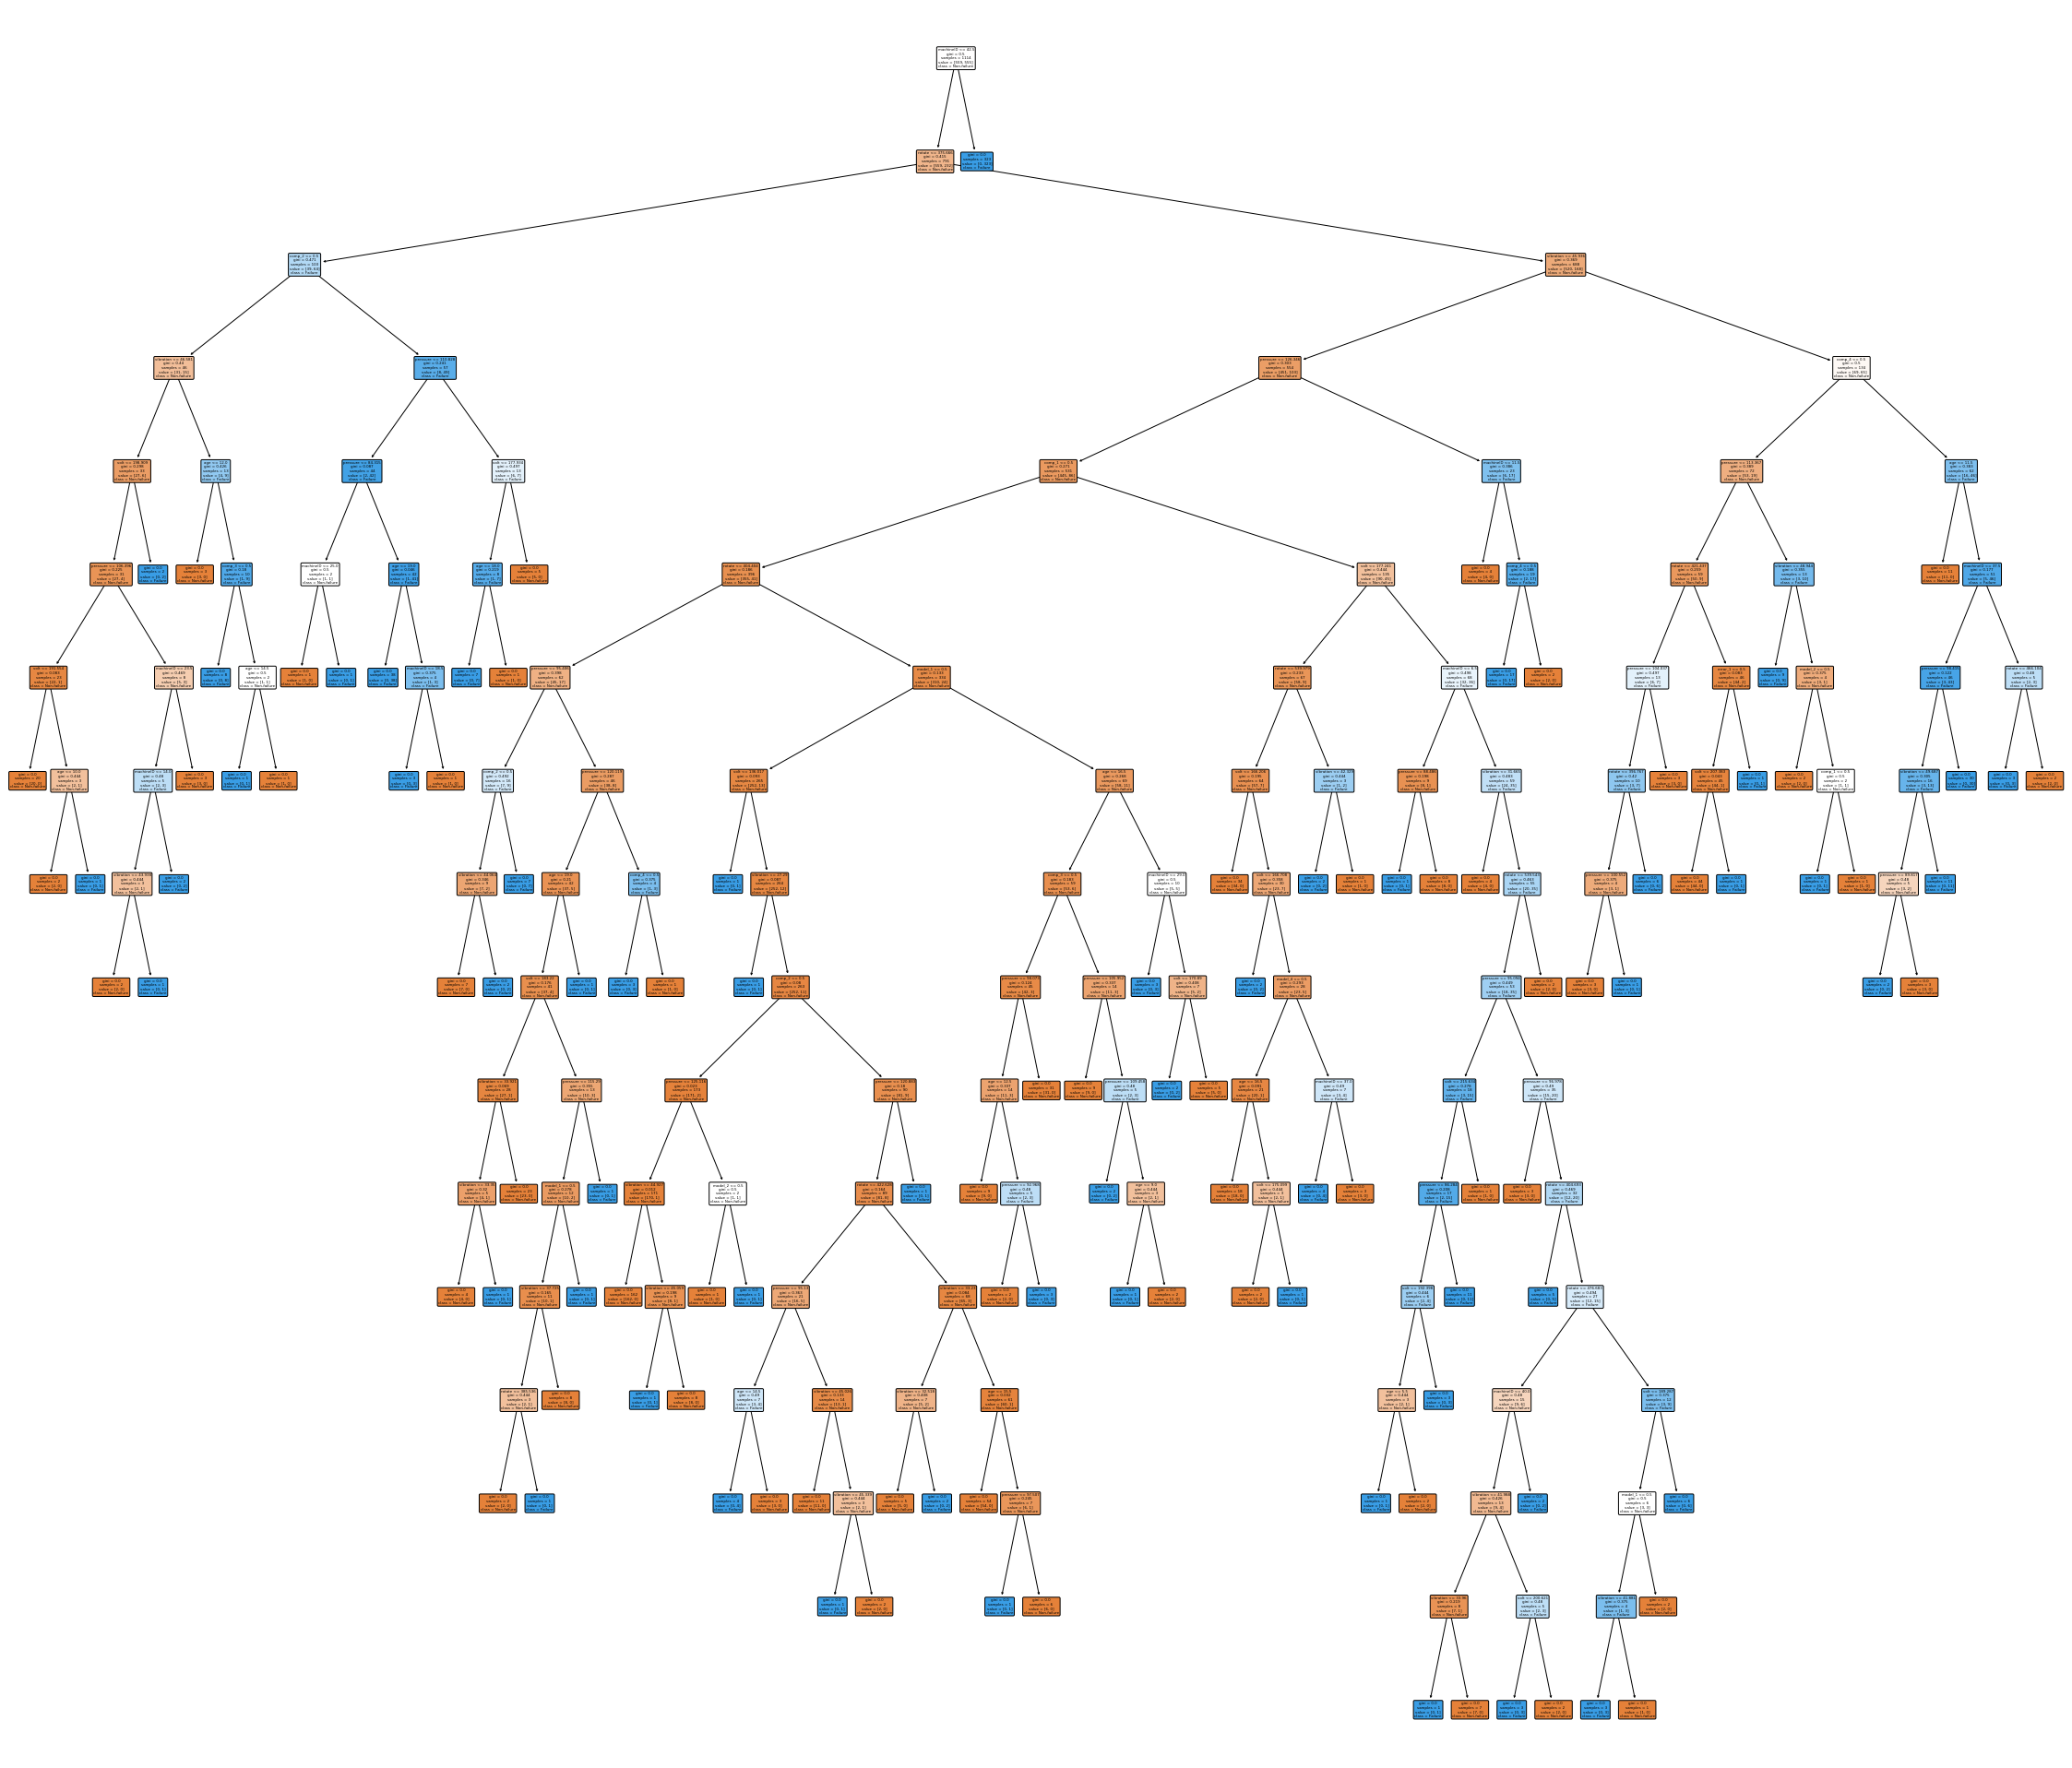

In [7]:
## Preliminary decision tree
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=42)

#Fitting X_train on y_train
clf_dt = DecisionTreeClassifier(random_state=42)
clf_dt = clf_dt.fit(X_train, y_train)

plt.figure(figsize=(40, 35))
plot_tree(clf_dt, filled=True, rounded= True, class_names=['Non-failure', 'Failure'], feature_names=X_encoded.columns)

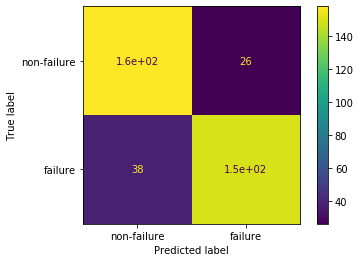

In [8]:
plot_confusion_matrix(clf_dt, X_test, y_test, display_labels=["non-failure", "failure"])

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

### Decision tree op dfSmall waarbij errors worden meegenomen en dummies worden aangemaakt

In [9]:
# Defining X and y
X = dfSmall.drop(['failure', 'date', 'timestamp'], axis=1).copy()
y = dfSmall['failure'].copy()

# One-hot-encoded for comp column
X_encoded = pd.get_dummies(X, columns=['comp', 'model', 'errorID'])

X_encoded.rename(columns={'comp_comp1': 'comp_1', 'comp_comp2': 'comp_2', 'comp_comp3': 'comp_3', 'comp_comp4': 'comp_4',
                          'model_model1': 'model_1', 'model_model2': 'model_2', 'model_model3': 'model_3', 'model_model4': 'model_4',
                          'errorID_error1': 'error_1', 'errorID_error2': 'error_2', 'errorID_error3': 'error_3', 'errorID_error4': 'error_4', 'errorID_error5': 'error_5' 
                          }, inplace=True)
X_encoded.head()

,machineID,age,volt,rotate,pressure,vibration,comp_1,comp_2,comp_3,comp_4,model_1,model_2,model_3,model_4,error_1,error_2,error_3,error_4,error_5
0,1,18,179.303153,499.777962,111.833028,52.383097,0,0,0,1,0,0,1,0,0,0,0,0,0
1,1,18,179.303153,499.777962,111.833028,52.383097,1,0,0,0,0,0,1,0,0,0,0,0,0
2,1,18,157.774510,442.816748,105.160692,42.135127,0,0,1,0,0,0,1,0,0,0,0,0,0
3,1,18,157.774510,442.816748,105.160692,42.135127,1,0,0,0,0,0,1,0,0,0,0,0,0
4,1,18,198.120032,438.210053,89.040265,41.887215,0,0,0,1,0,0,1,0,0,0,0,0,0


[Text(1381.2140664029976, 1862.9624999999999, 'vibration <= 46.749\ngini = 0.385\nsamples = 2164\nvalue = [1602, 562]\nclass = Non-failure'),
 Text(761.5730120732723, 1783.6875, 'rotate <= 362.149\ngini = 0.338\nsamples = 1804\nvalue = [1416, 388]\nclass = Non-failure'),
 Text(96.63946711074105, 1704.4125, 'comp_2 <= 0.5\ngini = 0.493\nsamples = 165\nvalue = [73, 92]\nclass = Failure'),
 Text(44.60283097418818, 1625.1374999999998, 'volt <= 189.81\ngini = 0.313\nsamples = 72\nvalue = [58, 14]\nclass = Non-failure'),
 Text(29.735220649458785, 1545.8625, 'volt <= 159.74\ngini = 0.206\nsamples = 60\nvalue = [53, 7]\nclass = Non-failure'),
 Text(22.30141548709409, 1466.5875, 'volt <= 148.176\ngini = 0.403\nsamples = 25\nvalue = [18, 7]\nclass = Non-failure'),
 Text(14.867610324729393, 1387.3125, 'gini = 0.0\nsamples = 12\nvalue = [12, 0]\nclass = Non-failure'),
 Text(29.735220649458785, 1387.3125, 'vibration <= 41.751\ngini = 0.497\nsamples = 13\nvalue = [6, 7]\nclass = Failure'),
 Text(14.

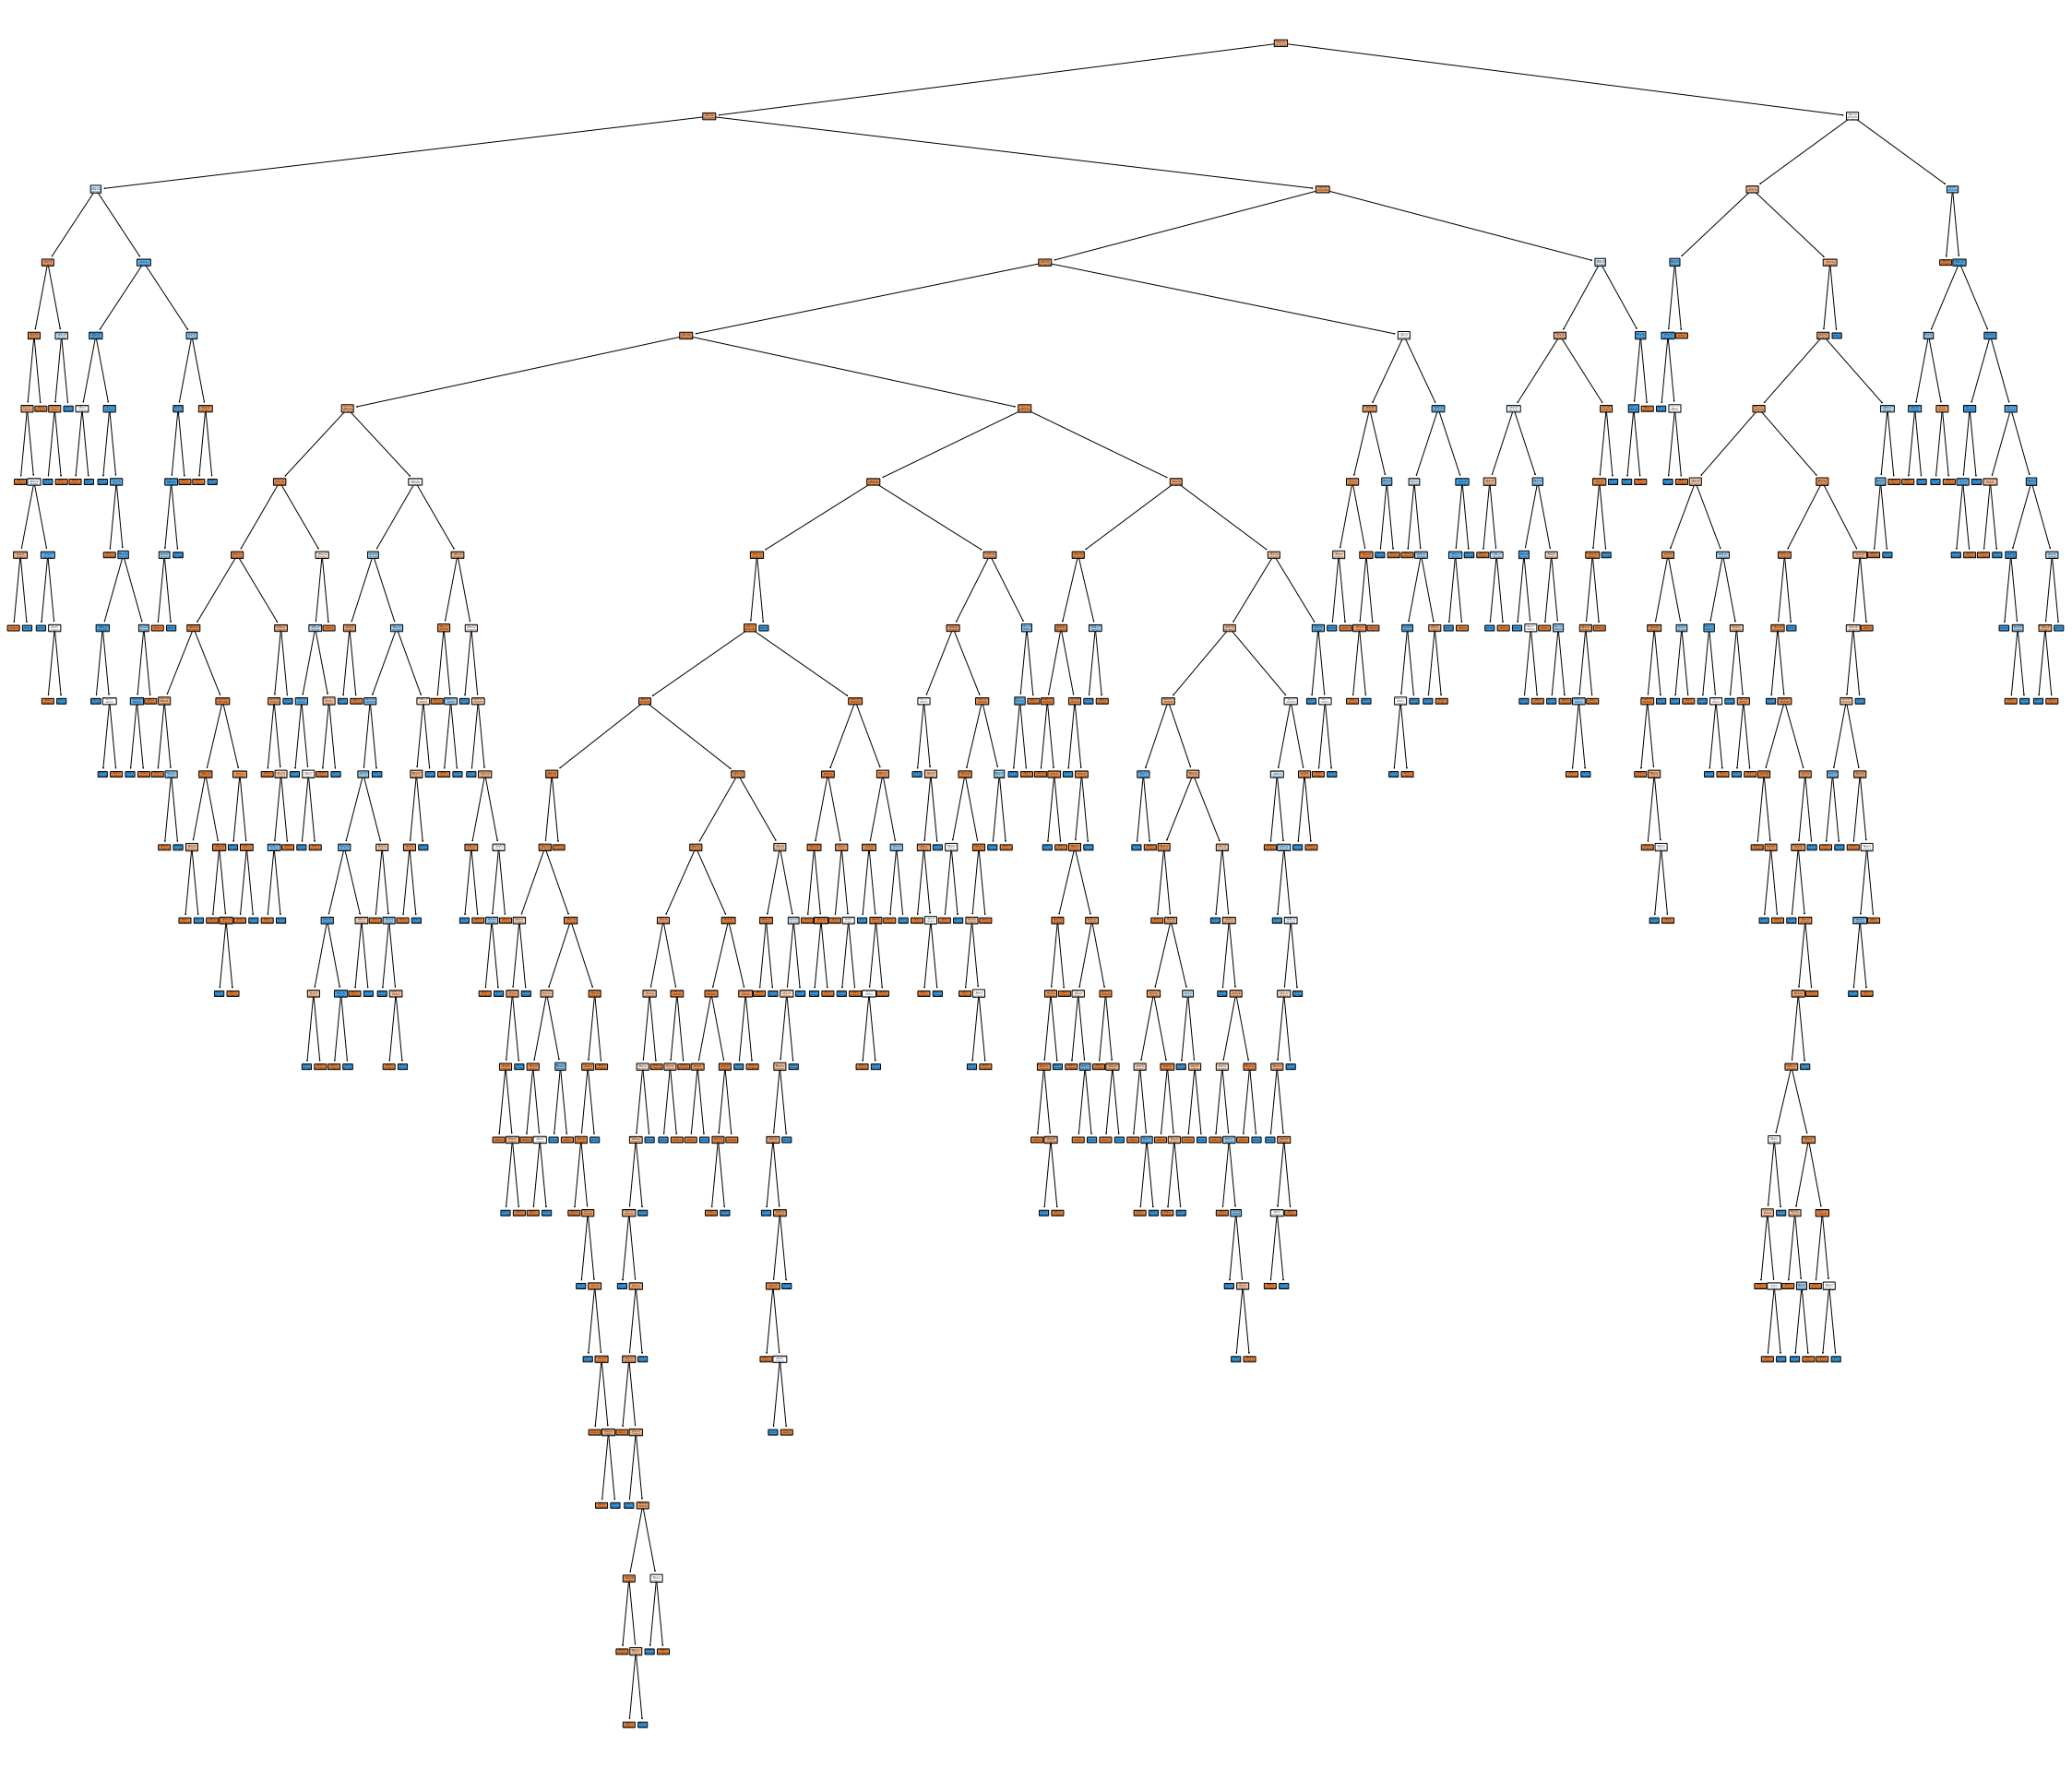

In [10]:
## Preliminary decision tree
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=42)

#Fitting X_train on y_train
clf_dt = DecisionTreeClassifier(random_state=42)
clf_dt = clf_dt.fit(X_train, y_train)

plt.figure(figsize=(40, 35))
plot_tree(clf_dt, filled=True, rounded= True, class_names=['Non-failure', 'Failure'], feature_names=X_encoded.columns)